## Experiment Notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


### Load data

In [3]:
transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Resize((224, 224)),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 52964652.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Load ResNet50 Teacher model

In [7]:
teacher = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 113MB/s]


In [8]:
# teacher.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher = teacher.to(device)

In [9]:
for param in teacher.parameters():
    param.requires_grad = True

### Fine Tune Teacher on Cifar10

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [11]:
num_epochs = 20
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
print_interval = 200

for epoch in range(num_epochs):
    teacher.train()
    current_loss = 0.0
    correct = 0
    total = 0

    # Train
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss.append(current_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)
    print('[%d] train_loss: %.3f, train_accuracy: %.2f %%' %
     (epoch + 1, current_loss / len(train_loader), 100 * correct / total))

    # Evaluate
    teacher.eval()
    correct_test = 0
    total_test = 0
    test_current_loss = 0.0
    with torch.no_grad():
      for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        test_current_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

    test_loss.append(test_current_loss / len(test_loader))
    test_accuracy.append(100 * correct_test / total_test)
    print('[%d] test_loss: %.3f, test_accuracy: %.2f %%' %
     (epoch + 1, test_current_loss / len(test_loader), 100 * correct_test / total_test))

    scheduler.step()



[1] train_loss: 1.111, train_accuracy: 61.46 %
[1] test_loss: 0.508, test_accuracy: 82.34 %
[2] train_loss: 0.773, train_accuracy: 73.14 %
[2] test_loss: 0.412, test_accuracy: 85.90 %
[3] train_loss: 0.707, train_accuracy: 75.36 %
[3] test_loss: 0.344, test_accuracy: 88.22 %
[4] train_loss: 0.667, train_accuracy: 76.88 %
[4] test_loss: 0.358, test_accuracy: 87.91 %
[5] train_loss: 0.652, train_accuracy: 77.38 %
[5] test_loss: 0.336, test_accuracy: 88.49 %
[6] train_loss: 0.477, train_accuracy: 83.70 %
[6] test_loss: 0.170, test_accuracy: 94.27 %
[7] train_loss: 0.415, train_accuracy: 85.56 %
[7] test_loss: 0.154, test_accuracy: 94.78 %
[8] train_loss: 0.394, train_accuracy: 86.32 %
[8] test_loss: 0.149, test_accuracy: 95.02 %
[9] train_loss: 0.382, train_accuracy: 86.69 %
[9] test_loss: 0.144, test_accuracy: 95.02 %
[10] train_loss: 0.369, train_accuracy: 87.43 %
[10] test_loss: 0.142, test_accuracy: 95.13 %
[11] train_loss: 0.343, train_accuracy: 88.08 %
[11] test_loss: 0.135, test_ac

KeyboardInterrupt: 

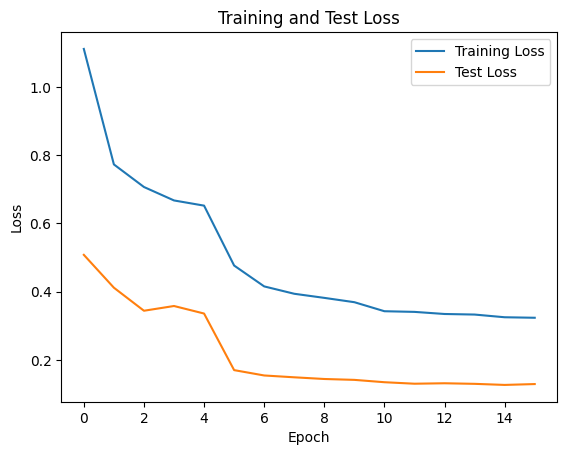

In [12]:
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

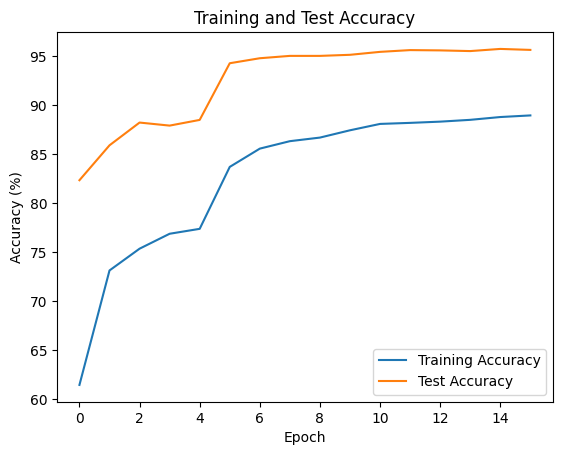

In [13]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.legend()
plt.show()

In [14]:
# torch.save(teacher.state_dict(), 'teacher_finetuned_cifar10.pth')
from google.colab import drive
drive.mount('/content/drive')
torch.save(teacher.state_dict(), "/content/drive/MyDrive/Colab Notebooks/teacher_finetuned_cifar10.pth")

Mounted at /content/drive
